THIS NOTEBOOK AIMS TO TRAIN VIT L 16 OXFORD III PETS DATASET

In [22]:
import torch
import torchvision
from torchinfo import summary
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms

In [23]:
torch.cuda.empty_cache()

In [24]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [25]:
vit_l_16_weights = torchvision.models.ViT_L_16_Weights.DEFAULT
vit_l_16_model = torchvision.models.vit_l_16(vit_l_16_weights).to(device)

In [26]:
from train_model import print_summary

In [27]:
summary(model=vit_l_16_model, 
          input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
          # col_names=["input_size"], # uncomment for smaller output
          col_names=["input_size", "output_size", "num_params", "trainable"],
          col_width=20,
          row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224]    [32, 1000]           1,024                True
├─Conv2d (conv_proj)                                         [32, 3, 224, 224]    [32, 1024, 14, 14]   787,456              True
├─Encoder (encoder)                                          [32, 197, 1024]      [32, 197, 1024]      201,728              True
│    └─Dropout (dropout)                                     [32, 197, 1024]      [32, 197, 1024]      --                   --
│    └─Sequential (layers)                                   [32, 197, 1024]      [32, 197, 1024]      --                   True
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 1024]      [32, 197, 1024]      12,596,224           True
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 1024]      [32, 197, 10

In [28]:
vit_transforms = vit_l_16_weights.transforms()
vit_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[242]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [29]:
dataset_dir = "../datasets/"

In [30]:
transform_tensor = transforms.Compose([
    transforms.Resize(size=[224]),
    transforms.ToTensor()])

In [31]:
train_data = torchvision.datasets.OxfordIIITPet(root=dataset_dir,
                                                download=True,
                                                split="trainval",
                                                transform=vit_transforms)
test_data = torchvision.datasets.OxfordIIITPet(root=dataset_dir,
                                                download=True,
                                                transform=vit_transforms,
                                                split="test")

In [32]:
from prepare_data import create_dataloaders
train_dataloader, test_dataloader, class_names = create_dataloaders(train_data=train_data, test_data=test_data, data_folder_imported=True, transform=vit_transforms, batch_size=128)

In [33]:
class_names

['Abyssinian',
 'American Bulldog',
 'American Pit Bull Terrier',
 'Basset Hound',
 'Beagle',
 'Bengal',
 'Birman',
 'Bombay',
 'Boxer',
 'British Shorthair',
 'Chihuahua',
 'Egyptian Mau',
 'English Cocker Spaniel',
 'English Setter',
 'German Shorthaired',
 'Great Pyrenees',
 'Havanese',
 'Japanese Chin',
 'Keeshond',
 'Leonberger',
 'Maine Coon',
 'Miniature Pinscher',
 'Newfoundland',
 'Persian',
 'Pomeranian',
 'Pug',
 'Ragdoll',
 'Russian Blue',
 'Saint Bernard',
 'Samoyed',
 'Scottish Terrier',
 'Shiba Inu',
 'Siamese',
 'Sphynx',
 'Staffordshire Bull Terrier',
 'Wheaten Terrier',
 'Yorkshire Terrier']

lets show some images

In [34]:
len(train_dataloader), len(test_dataloader)

(29, 29)

In [35]:
len(train_data)

3680

In [36]:
image_batch, label_batch = next(iter(train_dataloader))
image, label = image_batch[2], label_batch[2]

In [37]:
image.shape, label.shape

(torch.Size([3, 224, 224]), torch.Size([]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Boxer')

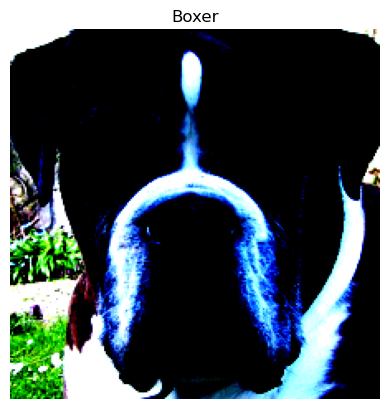

In [38]:
#should permute
plt.imshow(image.permute(1,2,0))
plt.axis(False)
plt.title(class_names[label])

In [39]:
for parameter in vit_l_16_model.parameters():
    parameter.requires_grad = False

In [40]:
vit_l_16_model.heads = nn.Sequential(nn.Linear(in_features=1024, out_features=len(class_names)))
summary(model=vit_l_16_model, 
          input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
          # col_names=["input_size"], # uncomment for smaller output
          col_names=["input_size", "output_size", "num_params", "trainable"],
          col_width=20,
          row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224]    [32, 37]             1,024                Partial
├─Conv2d (conv_proj)                                         [32, 3, 224, 224]    [32, 1024, 14, 14]   (787,456)            False
├─Encoder (encoder)                                          [32, 197, 1024]      [32, 197, 1024]      201,728              False
│    └─Dropout (dropout)                                     [32, 197, 1024]      [32, 197, 1024]      --                   --
│    └─Sequential (layers)                                   [32, 197, 1024]      [32, 197, 1024]      --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 1024]      [32, 197, 1024]      (12,596,224)         False
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 1024]      [32, 

learning rate decay(cosine), gradient clipping, learning rate warmup 

In [41]:
#learning scheduler for warmups and weight decays
optimizer = torch.optim.SGD(momentum=0.9, lr=0.001, params=vit_l_16_model.parameters())
loss_fn = nn.CrossEntropyLoss()
lr_sc = torch.optim.lr_scheduler.CosineAnnealingLR(T_max=500, optimizer=optimizer, verbose=False)

In [42]:
from train_model import train
vit_pets_results = train(model=vit_l_16_model,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        lr_scheduler=lr_sc,
                        epochs=14,
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        device=device)

  7%|▋         | 1/14 [01:26<18:50, 86.96s/it]

Learning Rate: 0.0009917226024976648
Epoch: 1 | train_loss: 3.4355 | train_acc: 0.1329 | test_loss: 3.1114 | test_acc: 0.4126


 14%|█▍        | 2/14 [02:54<17:25, 87.10s/it]

Learning Rate: 0.0009671644712283052
Epoch: 2 | train_loss: 2.7606 | train_acc: 0.6557 | test_loss: 2.4447 | test_acc: 0.7831


 21%|██▏       | 3/14 [04:21<15:57, 87.07s/it]

Learning Rate: 0.0009271387158496467
Epoch: 3 | train_loss: 2.1430 | train_acc: 0.8366 | test_loss: 1.9117 | test_acc: 0.8497


 29%|██▊       | 4/14 [05:48<14:32, 87.22s/it]

Learning Rate: 0.00087297057271209
Epoch: 4 | train_loss: 1.6733 | train_acc: 0.8869 | test_loss: 1.5249 | test_acc: 0.8769


 36%|███▌      | 5/14 [07:15<13:05, 87.24s/it]

Learning Rate: 0.0008064535268264872
Epoch: 5 | train_loss: 1.3441 | train_acc: 0.9049 | test_loss: 1.2590 | test_acc: 0.8863


 43%|████▎     | 6/14 [08:43<11:38, 87.30s/it]

Learning Rate: 0.0007297899303107428
Epoch: 6 | train_loss: 1.1206 | train_acc: 0.9178 | test_loss: 1.0814 | test_acc: 0.8941


 50%|█████     | 7/14 [10:10<10:11, 87.29s/it]

Learning Rate: 0.000645518083414135
Epoch: 7 | train_loss: 0.9708 | train_acc: 0.9223 | test_loss: 0.9619 | test_acc: 0.8987


 57%|█████▋    | 8/14 [11:37<08:43, 87.28s/it]

Learning Rate: 0.0005564281924367399
Epoch: 8 | train_loss: 0.8692 | train_acc: 0.9309 | test_loss: 0.8797 | test_acc: 0.9030


 64%|██████▍   | 9/14 [13:05<07:16, 87.30s/it]

Learning Rate: 0.0004654699871427964
Epoch: 9 | train_loss: 0.7986 | train_acc: 0.9343 | test_loss: 0.8226 | test_acc: 0.9033


 71%|███████▏  | 10/14 [14:32<05:49, 87.28s/it]

Learning Rate: 0.00037565505641757197
Epoch: 10 | train_loss: 0.7491 | train_acc: 0.9367 | test_loss: 0.7824 | test_acc: 0.9038


 79%|███████▊  | 11/14 [15:59<04:21, 87.29s/it]

Learning Rate: 0.0002899571357940963
Epoch: 11 | train_loss: 0.7143 | train_acc: 0.9385 | test_loss: 0.7542 | test_acc: 0.9041


 86%|████████▌ | 12/14 [17:27<02:54, 87.29s/it]

Learning Rate: 0.00021121364828886592
Epoch: 12 | train_loss: 0.6891 | train_acc: 0.9387 | test_loss: 0.7348 | test_acc: 0.9044


 93%|█████████▎| 13/14 [18:54<01:27, 87.29s/it]

Learning Rate: 0.0001420317584890842
Epoch: 13 | train_loss: 0.6731 | train_acc: 0.9402 | test_loss: 0.7221 | test_acc: 0.9044


100%|██████████| 14/14 [20:21<00:00, 87.27s/it]

Learning Rate: 8.47020504020936e-05
Epoch: 14 | train_loss: 0.6621 | train_acc: 0.9401 | test_loss: 0.7142 | test_acc: 0.9052


So first results with cosinelearning rate was really baddd so lets try to read paper again

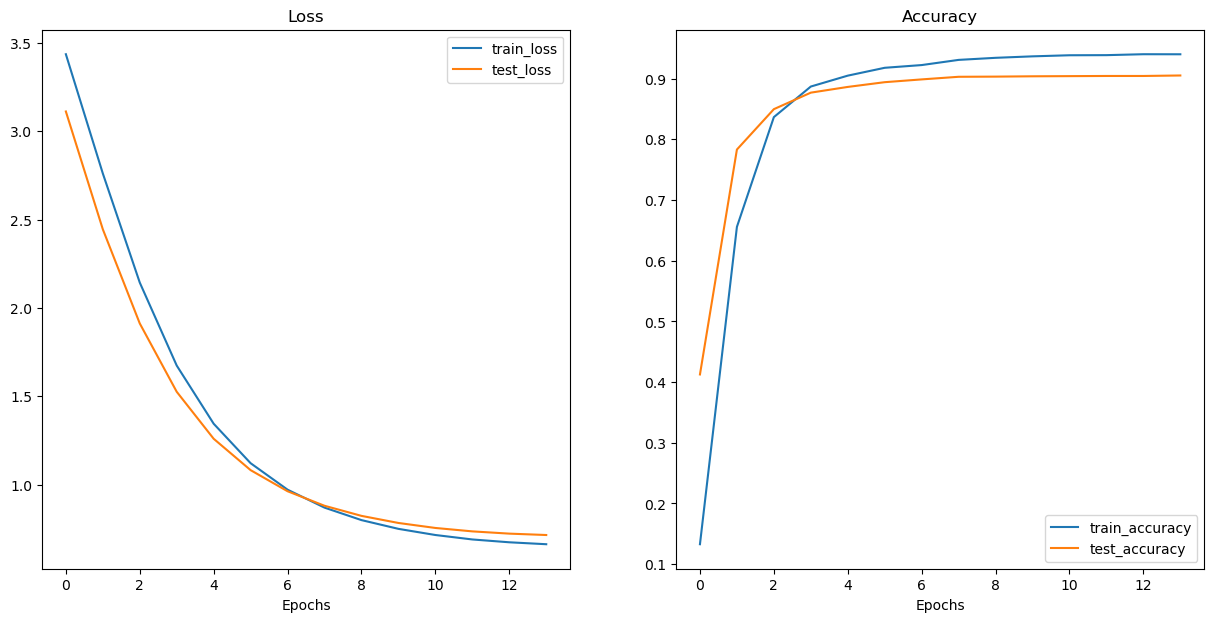

In [43]:
from plot_loss_function import plot_loss_function

plot_loss_function(vit_pets_results)